## Flux components 

There is probably a lot more going on with the sub-grid fluxes than just dissipation, so we can try to understand the impact the different components the flux and their flux divergences have. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xgcm import Grid
#from xmitgcm import open_mdsdataset
import xrft
#from scipy.ndimage import gaussian_filter
import gcm_filters as gcmf

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']

We want to work with the raw data and only generate the filtered fields. 
This is mostly to just have the right grids (the ML data we generated was only a C-grid). 

In [3]:
import gcsfs
fs = gcsfs.GCSFileSystem()
fs.ls(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/')

['leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge300day',
 'leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge60day']

In [4]:
ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge10day/prog.zarr')

In [5]:
ds = ds.chunk({'Time':1,'xh':-1,'yh':-1,'xq':-1,'yq':-1})

In [6]:
ds

<xarray.Dataset>
Dimensions:  (Time: 360, zl: 2, yh: 400, xh: 300, yq: 401, xq: 301, zi: 3)
Coordinates:
  * Time     (Time) object 0001-01-11 00:00:00 ... 0010-11-10 00:00:00
  * xh       (xh) float64 2.0 6.0 10.0 14.0 ... 1.19e+03 1.194e+03 1.198e+03
  * xq       (xq) float64 0.0 4.0 8.0 12.0 ... 1.192e+03 1.196e+03 1.2e+03
  * yh       (yh) float64 2.0 6.0 10.0 14.0 ... 1.59e+03 1.594e+03 1.598e+03
  * yq       (yq) float64 0.0 4.0 8.0 12.0 ... 1.592e+03 1.596e+03 1.6e+03
  * zi       (zi) float64 1.03e+03 1.032e+03 1.034e+03
  * zl       (zl) float64 1.031e+03 1.033e+03
Data variables:
    Ahh      (Time, zl, yh, xh) float32 dask.array<chunksize=(1, 1, 400, 300), meta=np.ndarray>
    Ahq      (Time, zl, yq, xq) float32 dask.array<chunksize=(1, 1, 401, 301), meta=np.ndarray>
    PV       (Time, zl, yq, xq) float32 dask.array<chunksize=(1, 1, 401, 301), meta=np.ndarray>
    RV       (Time, zl, yq, xq) float32 dask.array<chunksize=(1, 1, 401, 301), meta=np.ndarray>
    Rd_dx    (Time, yh, xh) float32 dask.array<chunksize=(1, 400, 300), meta=np.ndarray>
    cg1      (Time, yh, xh) float32 dask.array<chunksize=(1, 400, 300), meta=np.ndarray>
    e        (Time, zi, yh, xh) float32 dask.array<chunksize=(1, 1, 400, 300), meta=np.ndarray>
    h        (Time, zl, yh, xh) float64 dask.array<chunksize=(1, 1, 400, 300), meta=np.ndarray>
    slope_x  (Time, zi, yh, xq) float64 dask.array<chunksize=(1, 1, 400, 301), meta=np.ndarray>
    slope_y  (Time, zi, yq, xh) float64 dask.array<chunksize=(1, 1, 401, 300), meta=np.ndarray>
    u        (Time, zl, yh, xq) float32 dask.array<chunksize=(1, 1, 400, 301), meta=np.ndarray>
    v        (Time, zl, yq, xh) float32 dask.array<chunksize=(1, 1, 401, 300), meta=np.ndarray>
Attributes:
    filename:   prog.nc
    grid_tile:  N/A
    grid_type:  regular
    title:      Phillips experiment

In [7]:
def filter_dataset(ds, Lfilter): 
    
    dx = ds.xh.diff('xh')[0].values*1e3
    wet_mask= (ds.h.isel(Time=0, zl=0)*0. + 1.).rename('wet_mask')
    
    filter_C = gcmf.Filter(filter_scale= Lfilter,  
                     dx_min = dx, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND,
                     grid_vars = {'wet_mask': wet_mask})
    
    xgrid = Grid(ds, coords={'X': {'center': 'xh', 'outer': 'xq'},
                         'Y': {'center': 'yh', 'outer': 'yq'},
                         'Z': {'center': 'zl', 'outer': 'zi'} },
             periodic=['X'])
    
    ds_filt = xr.Dataset() # For storing the filtered data 
    print('Started')
    ds_filt['h'] = filter_C.apply(ds.h, dims=['yh','xh']).rename('h')
    ds_filt['e'] = filter_C.apply(ds.e, dims=['yh','xh']).rename('e')
    u_c = xgrid.interp(ds.u.fillna(0), 'X')
    v_c = xgrid.interp(ds.v.fillna(0), 'Y')
    ds_filt['u'] = filter_C.apply(u_c, dims=['yh','xh']).rename('u')
    ds_filt['v'] = filter_C.apply(v_c, dims=['yh','xh']).rename('v')
    
    print('Filtered fields computed')
    
    ds_filt['uh'] = ds.h*u_c
    ds_filt['vh'] = ds.h*v_c
    
    ds_filt['uh_bar'] = filter_C.apply(ds_filt['uh'], dims=['yh','xh']).rename('uh_bar')
    ds_filt['vh_bar'] = filter_C.apply(ds_filt['vh'], dims=['yh','xh']).rename('vh_bar')
    
    ds_filt['ubar_hbar'] = (ds_filt.h*ds_filt.u)
    ds_filt['vbar_hbar'] = (ds_filt.h*ds_filt.v)
    
    ds_filt['uh_sg'] = ds_filt['uh_bar'] - ds_filt['ubar_hbar']
    ds_filt['vh_sg'] = ds_filt['vh_bar'] - ds_filt['vbar_hbar']

    print('Fluxes computed')
    
    ds_filt['dudx'] = xgrid.interp(xgrid.diff(ds_filt.u, 'X')/dx, 'X')
    ds_filt['dvdx'] = xgrid.interp(xgrid.diff(ds_filt.v, 'X')/dx, 'X')
    ds_filt['dudy'] = xgrid.interp(xgrid.diff(ds_filt.u, 'Y')/dx, 'Y')
    ds_filt['dvdy'] = xgrid.interp(xgrid.diff(ds_filt.v, 'Y')/dx, 'Y')
    ds_filt['slope_x'] = xgrid.interp(xgrid.diff(ds_filt.e, 'X')/dx, 'X')
    ds_filt['slope_y'] = xgrid.interp(xgrid.diff(ds_filt.e, 'Y')/dx, 'Y')
    
    print('Gradients computed')
    
    return ds_filt

In [8]:
ds_filt = filter_dataset(ds, 100e3)

Started
Filtered fields computed
Fluxes computed
Gradients computed


In [10]:
xgrid = Grid(ds, coords={'X': {'center': 'xh', 'outer': 'xq'},
                         'Y': {'center': 'yh', 'outer': 'yq'},
                         'Z': {'center': 'zl', 'outer': 'zi'} },
             periodic=['X'])

In [11]:
def return_right_var_names(ds_L, L): 
    
    ds_test = xr.Dataset()
    
    ds_test['Sx'] = ds_L.slope_x.isel(zi=1)
    ds_test['Sy'] = ds_L.slope_y.isel(zi=1)
    ds_test['Lfilt'] = ds_L.h.isel(zl=0)*0. + L
    
    # For the gradients we have some choices to make 
    
    choice = 1 # 0 thickness weighted, 1 bottom layer, 2 top layer
    # Choose 0, since that is what we are currently using in online sims
    if choice == 0:
        ds_test['U_x'] = (ds_L.dudx * ds_L.h).sum('zl') / ds_L.h.sum('zl') #* 0.
        ds_test['U_y'] = (ds_L.dudy * ds_L.h).sum('zl') / ds_L.h.sum('zl') #* 0.
        ds_test['V_x'] = (ds_L.dvdx * ds_L.h).sum('zl') / ds_L.h.sum('zl') #* 0.
        ds_test['V_y'] = (ds_L.dvdy * ds_L.h).sum('zl') / ds_L.h.sum('zl') #* 0.
    elif choice ==1: 
        ds_test['U_x'] = ds_L.dudx.isel(zl=1)
        ds_test['U_y'] = ds_L.dudy.isel(zl=1)
        ds_test['V_x'] = ds_L.dvdx.isel(zl=1)
        ds_test['V_y'] = ds_L.dvdy.isel(zl=1)
        
    ds_test['Sfnx'] = ds_L.uh_sg.isel(zl=1)
    ds_test['Sfny'] = ds_L.vh_sg.isel(zl=1)
    
    return ds_test

In [12]:
ds_ML = return_right_var_names(ds_filt, 100)

### Dissipation 

In [13]:
def dissipative_prop(ds, Sfnx='Sfnx', Sfny='Sfny', norm=True):

    S_mag = ds.Sx*ds.Sx + ds.Sy*ds.Sy
    diss_true = ds.Sx*ds[Sfnx] + ds.Sy*ds[Sfny]
    #diss_pred = ds.Sx*ds_pred.Sfnx + ds.Sy*ds_pred.Sfny
    
    if norm==True:
        return diss_true/S_mag#, diss_pred/S_mag
    else:
        return diss_true

In [14]:
diss_L = dissipative_prop(ds_ML)

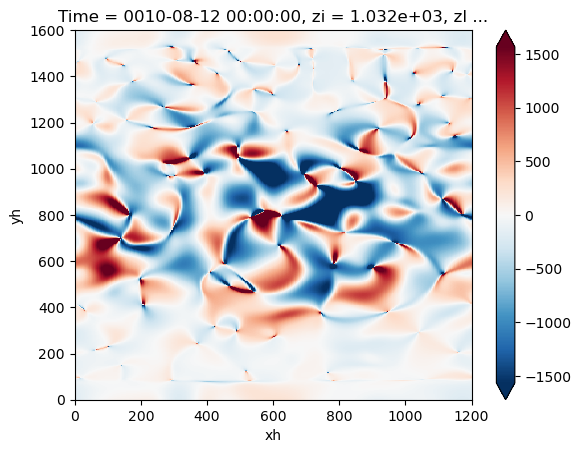

In [15]:
diss_L.isel(Time=-10).plot(robust=True)

### Projection 

In [54]:
def perp_para(ds): 
    
    S_mag = ds.Sx * ds.Sx + ds.Sy * ds.Sy
    Sfn_perp_mag = (ds.Sfnx * ds.Sx + ds.Sfny * ds.Sy)/S_mag 
    
    ds['Sfnx_perp'] = Sfn_perp_mag * ds.Sx 
    ds['Sfny_perp'] = Sfn_perp_mag * ds.Sy
    
    ds['Sfnx_para'] = ds['Sfnx'] -  ds['Sfnx_perp']
    ds['Sfny_para'] = ds['Sfny'] -  ds['Sfny_perp']
    
    return ds

In [55]:
ds = perp_para(ds_ML)

In [56]:
diss_perp = dissipative_prop(ds, 'Sfnx_perp','Sfny_perp', norm=False)
diss_para = dissipative_prop(ds, 'Sfnx_para','Sfny_para', norm=False) #should be zero

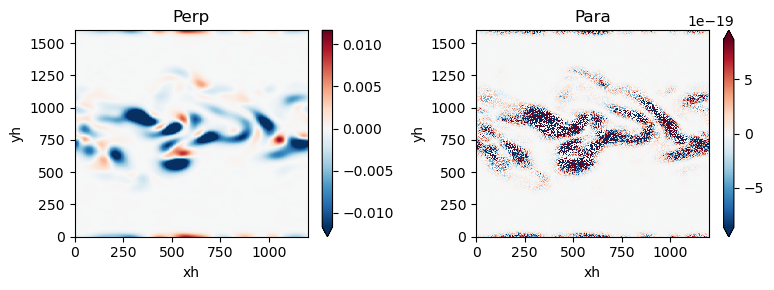

In [57]:
plt.figure(figsize=(8,3)) 

plt.subplot(121)
diss_perp.isel(Time=-1).plot(robust=True)
plt.title('Perp')

plt.subplot(122)
diss_para.isel(Time=-1).plot(robust=True)
plt.title('Para')

plt.tight_layout()

### Flux div

In [58]:
def flux_div(ds, xgrid, xflux='Sfnx', yflux='Sfny'):
    Fx = ds[xflux]
    Fy = ds[yflux]

    dx = ds.xh.diff('xh')[0].values*1e3

    dFdx = xgrid.interp(xgrid.diff(Fx,'X')/dx, 'X')
    dFdy = xgrid.interp(xgrid.diff(Fy,'Y')/dx, 'Y')

    divF = dFdx + dFdy
    
    return divF, dFdx, dFdy

In [59]:
divF, _, _ = flux_div(ds, xgrid)
divF_para, _, _ = flux_div(ds, xgrid, xflux='Sfnx_para', yflux='Sfny_para')
divF_perp, _, _ = flux_div(ds, xgrid, xflux='Sfnx_perp', yflux='Sfny_perp')

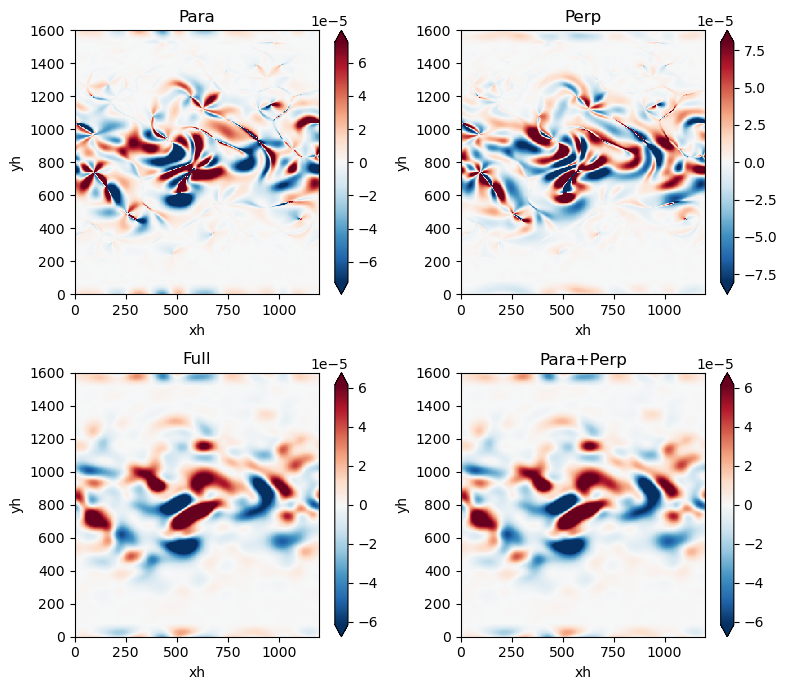

In [62]:
plt.figure(figsize=(8, 7))

plt.subplot(221)
divF_para.isel(Time=-1).plot(robust=True)
plt.title('Para')

plt.subplot(222)
divF_perp.isel(Time=-1).plot(robust=True)
plt.title('Perp')

plt.subplot(223)
divF.isel(Time=-1).plot(robust=True)
plt.title('Full')

plt.subplot(224)
(divF_para + divF_perp).isel(Time=-1).plot(robust=True)
plt.title('Para+Perp')

plt.tight_layout()

In summary the decomposition into parallel and perpendicular components is relatively artifical. Both components project onto the flux divergence, and can potentially be important in the dynamics of the system. 

But question remains: what is the impact of the parallel component on the dynamics? 